In [1]:
# type:ignore
import xarray as xr
import numpy as np
import pandas as pd
import h5py
import os
import shutil
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature

from pathlib import Path
from sklearn.preprocessing import MinMaxScaler
from myLibrary import convertTime, inverseLogTransform, inversTransform, image2Xarray, selectPrecipitation, logTransform

# Set datasets name
DatasetsName        = 'JI_LT_N_025_01_V2'
# GJ: Greater Jakarta, JI: Java Island, IA: Indonesia
# LT: Log Transformatation
# N: Normalization
# A: Augmentation
# 05: Low Resolution Scale: 0.5
# 04: Low Resolution Scale: 0.4
# 03: Low Resolution Scale: 0.3
# 02: Low Resolution Scale: 0.2
# 01: High Resolution Scale: 0.1
# QT: Quantile Transformation

# Define the cropping bounds (Indonesia Region)
# lat_min, lat_max = 6.05, -11.05     # Latitude range    : 
# lon_min, lon_max = 95.05, 143.05    # Longitude range   : 48° (480 pixels in 0.1°)

# Define the cropping bounds (Greater Jakarta Region)
# lat_min, lat_max = -5.85, -7.45     # Latitude range    : 1.6° (16 pixels in 0.1°) ~ -6.80 to -6.05
# lon_min, lon_max = 106.05, 107.65   # Longitude range   : 1.6° (16 pixels in 0.1°) ~ 106.50 to 107.20 

# Define the cropping bounds (Java Island Region)
lat_min, lat_max = -5.65, -8.95     # Latitude range    : 3.2° (32 pixels in 0.1°)
lon_min, lon_max = 105.15, 114.75   # Longitude range   : 9.6° (96 pixels in 0.1°)

# Define the cropping bounds (Java Island Region)
# lat_min, lat_max = -5.45, -8.95     # Latitude range    : 3.5° (35 pixels in 0.1°)
# lon_min, lon_max = 104.95, 114.90   # Longitude range   : 10.0° (100 pixels in 0.1°)

# Define the desired coarsening degree (e.g., 0.5° x 0.5° resolution)
lowResDegree        = 0.25  # Change this based on your needs

# Define the target resolution (e.g., 0.1°)
highResDegree       = 0.1  # Change this to your desired resolution

# Define Precipitation Threshold
removeOutlier       = False
outlierThreshold    = 50

# Define PreProcessing Method
DoPreProcessing     = True

# Define Normalized
Normalized          = True

# Define Augmentation


In [2]:
# Path Define
# Get the absolute path 
pathNow = Path().parent.absolute()
pathNow = pathNow.parent.parent
print(pathNow)

# Define the base directory where MSWEP files are stored
mswepDir = str(pathNow) + "/Datasets/Ina_MSWEP/"

# Report Filename
# DatasetsFolder      =  str(pathNow) + '\\Adhi.Code\\Datasets\\' + DatasetsName 
DatasetsFolder      =  pathNow / 'Hasan.Code' / 'Datasets' / DatasetsName 

# Create folder and delete if exists
if os.path.exists(DatasetsFolder):
    shutil.rmtree(DatasetsFolder)
os.makedirs(DatasetsFolder)

# Define training, validation, and testing year
# yearTrain       = np.arange(2011, 2025)  # 2011 to 2024 (70%)
# yearValidation  = np.arange(2008, 2011)  # 2008 to 2010 (15%)
# yearTesting     = np.arange(2005, 2008)  # 2005 to 2007 (15%)

yearTrain       = np.arange(2005, 2019)  # 2005 to 2018 (70%)
yearValidation  = np.arange(2019, 2022)  # 2019 to 2021 (15%)
yearTesting     = np.arange(2022, 2025)  # 2022 to 2024 (15%)

# Loop through years and create filenames
fileTrain       = [f"{mswepDir}merged_daily_{year}.nc" for year in yearTrain]
fileValidation  = [f"{mswepDir}merged_daily_{year}.nc" for year in yearValidation]
fileTesting     = [f"{mswepDir}merged_daily_{year}.nc" for year in yearTesting]

# Define HDF5 file name
hdf5Training    = DatasetsFolder / "mswepTrain.h5"
hdf5Validation  = DatasetsFolder / "mswepValidation.h5"
hdf5Testing     = DatasetsFolder / "mswepTesting.h5"
print(hdf5Training)

d:\UNIVERSITAS INDONESIA\BMKG Research 3 - 2025.PrecipitationProjection
d:\UNIVERSITAS INDONESIA\BMKG Research 3 - 2025.PrecipitationProjection\Hasan.Code\Datasets\JI_LT_N_025_01_V2\mswepTrain.h5


### Load multiple years into a single dataset

In [3]:
datasets        = [xr.open_dataset(fp) for fp in fileTrain]
dsTrain         = xr.concat(datasets, dim="time")  # Merge by time dimension

datasets        = [xr.open_dataset(fp) for fp in fileValidation]
dsValidation    = xr.concat(datasets, dim="time")  # Merge by time dimension

datasets        = [xr.open_dataset(fp) for fp in fileTesting]
dsTesting       = xr.concat(datasets, dim="time")  # Merge by time dimension

time_coord  = dsTrain.coords['time']
time_info   = {}

# Extract basic time information
time_info['time_units'] = time_coord.attrs.get('units', 'Not specified')
time_info['calendar']   = time_coord.attrs.get('calendar', 'Not specified')
time_info['start_date'] = pd.Timestamp(time_coord.values[0]).strftime('%Y-%m-%d %H:%M:%S')
time_info['end_date']   = pd.Timestamp(time_coord.values[-1]).strftime('%Y-%m-%d %H:%M:%S')
time_info['num_timesteps'] = len(time_coord)

# Calculate time resolution
if len(time_coord) > 1:
    time_diff = pd.Timestamp(time_coord.values[1]) - pd.Timestamp(time_coord.values[0])
    time_info['time_resolution'] = str(time_diff)
    
    # Check if time steps are regular
    time_diffs = np.array([
        (pd.Timestamp(time_coord.values[i+1]) - pd.Timestamp(time_coord.values[i])).total_seconds()
        for i in range(len(time_coord)-1)
    ])
    time_info['regular_timesteps'] = np.allclose(time_diffs, time_diffs[0])
else:
    time_info['time_resolution'] = 'Single timestep'
    time_info['regular_timesteps'] = None

# Extract all years, months, and available time periods
dates = pd.DatetimeIndex(time_coord.values)
time_info['years'] = sorted(list(set(dates.year)))
time_info['months'] = sorted(list(set(dates.month)))
time_info['days'] = sorted(list(set(dates.day)))
time_info['hours'] = sorted(list(set(dates.hour)))

print("\n===== MSWEP Time Details =====")
print(f"Time units: {time_info['time_units']}")
print(f"Calendar: {time_info['calendar']}")
print(f"Start date: {time_info['start_date']}")
print(f"End date: {time_info['end_date']}")
print(f"Number of timesteps: {time_info['num_timesteps']}")
print(f"Time resolution: {time_info['time_resolution']}")
print(f"Regular timesteps: {time_info['regular_timesteps']}")
print(f"Years available: {time_info['years']}")
print(f"Months available: {time_info['months']}")
print(f"Days available: {time_info['days']}")
print(f"Hours available: {time_info['hours']}")


===== MSWEP Time Details =====
Time units: Not specified
Calendar: Not specified
Start date: 2005-01-01 00:00:00
End date: 2018-12-31 00:00:00
Number of timesteps: 5113
Time resolution: 1 days 00:00:00
Regular timesteps: True
Years available: [2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018]
Months available: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]
Days available: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31]
Hours available: [0]


In [4]:
latOriginal, lonOriginal = dsTrain["lat"].values, dsTrain["lon"].values
# print('\nLatitude Original MSWEP:\n', latOriginal, '\nLongitude Original MSWEP:\n', lonOriginal)
print("\nOriginal Dataset dimensions:", dsTrain.dims)


Original Dataset dimensions: FrozenMappingWarningOnValuesAccess({'time': 5113, 'lat': 180, 'lon': 476})


In [5]:
precipTrain     = dsTrain['precipitation']
precipVal       = dsValidation['precipitation']
precipTest      = dsTesting['precipitation']

print('\nTraining Datasets:')
print(dsTrain)
print('\nValidation Datasets:')
print(dsValidation)
print('\nTesting Datasets:')
print(dsTesting)


Training Datasets:
<xarray.Dataset> Size: 2GB
Dimensions:        (time: 5113, lat: 180, lon: 476)
Coordinates:
  * time           (time) datetime64[ns] 41kB 2005-01-01 ... 2018-12-31
  * lon            (lon) float32 2kB 94.45 94.55 94.65 ... 141.8 141.9 141.9
  * lat            (lat) float32 720B 6.95 6.85 6.75 ... -10.75 -10.85 -10.95
Data variables:
    precipitation  (time, lat, lon) float32 2GB 7.375 7.562 ... 27.06 24.31
Attributes:
    CDI:          Climate Data Interface version 2.1.1 (https://mpimet.mpg.de...
    Conventions:  CF-1.6
    history:      Fri Feb 07 10:32:00 2025: cdo sellonlatbox,94.4,142,-11,7 m...
    CDO:          Climate Data Operators version 2.1.1 (https://mpimet.mpg.de...

Validation Datasets:
<xarray.Dataset> Size: 376MB
Dimensions:        (time: 1096, lat: 180, lon: 476)
Coordinates:
  * time           (time) datetime64[ns] 9kB 2019-01-01 ... 2021-12-31
  * lon            (lon) float32 2kB 94.45 94.55 94.65 ... 141.8 141.9 141.9
  * lat            (lat) 

### Upscale to Low Res Degree (Ex. 0.5°)

In [ ]:
# # Calculate the coarsening factor
# lat_res = np.abs(dsTrain.lat[1] - dsTrain.lat[0])  # Latitude resolution in degrees
# lon_res = np.abs(dsTrain.lon[1] - dsTrain.lon[0])  # Longitude resolution in degrees

# lat_res = np.round(lat_res, 1)
# lon_res = np.round(lon_res, 1)

# lat_factor = int(np.round(lowResDegree / lat_res, 0))
# lon_factor = int(np.round(lowResDegree / lon_res, 0))
# print(f"Upscaled Factor: {lat_factor} x {lon_factor}")

# # Apply block averaging using .coarsen()
# dsLowResTrain   = dsTrain.coarsen(lat=lat_factor, lon=lon_factor, boundary="trim").mean()
# dsLowResVal     = dsValidation.coarsen(lat=lat_factor, lon=lon_factor, boundary="trim").mean()
# dsLowResTest    = dsTesting.coarsen(lat=lat_factor, lon=lon_factor, boundary="trim").mean()

In [7]:
def changeScale(ds, target_resolution=0.25):
    """
    Change scale MSWEP precipitation data from 0.1° to 0.25° resolution.
    
    Parameters:
    -----------
    input_file : str
        Path to the input MSWEP precipitation file (NetCDF or similar format)
    output_file : str
        Path where the downscaled data will be saved
    target_resolution : float
        Target resolution in degrees (default: 0.25°)
    """
       
    # Get original resolution
    lats = ds.lat if 'lat' in ds.dims else ds.latitude
    lons = ds.lon if 'lon' in ds.dims else ds.longitude
    orig_res = abs(float(lats[1] - lats[0]))
    print(f"Original Resolution: {orig_res:.4f}°")
    print(f"Target resolution: {target_resolution:.4f}°")
    
    # Calculate aggregation factor (how many cells to combine)
    agg_factor = int(round(target_resolution / orig_res))
    print(f"Aggregation factor: {agg_factor}")
    
    lat_ascending = lats[1] > lats[0]
    lon_ascending = lons[1] > lons[0]
    
    if lat_ascending:
        lat_min, lat_max = float(lats.min()), float(lats.max())
        new_lats = np.arange(lat_min + target_resolution/2, lat_max, target_resolution)
    else:
        lat_max, lat_min = float(lats[0]), float(lats[-1])
        new_lats = np.arange(lat_max - target_resolution/2, lat_min, -target_resolution)

    # Longitude range and new longitudes
    if lon_ascending:
        lon_min, lon_max = float(lons.min()), float(lons.max())
        new_lons = np.arange(lon_min + target_resolution/2, lon_max, target_resolution)
    else:
        lon_max, lon_min = float(lons[0]), float(lons[-1])
        new_lons = np.arange(lon_max - target_resolution/2, lon_min, -target_resolution)
    
    # # Create new coordinate arrays
    # new_lats = np.arange(lat_min + target_resolution/2, lat_max, target_resolution)
    # new_lons = np.arange(lon_min + target_resolution/2, lon_max, target_resolution)
    
    # Create a new dataset with the target resolution
    ds      = ds.assign_coords(lat=lats, lon=lons)
    new_ds  = ds.interp(lat=new_lats, lon=new_lons, method='linear')
    
    return new_ds

In [ ]:
# # Define 0.25° target grid
# target_lat = np.arange(dsTrain.lat.max().item(), dsTrain.lat.min().item() - 0.25, -0.25)
# target_lon = np.arange(dsTrain.lon.min().item(), dsTrain.lon.max().item(), 0.25)

# ---------

# num_lat = int(round((dsTrain.lat.max().item() - dsTrain.lat.min().item()) / 0.25)) + 1
# target_lat = np.linspace(dsTrain.lat.max().item(), dsTrain.lat.min().item(), num_lat)

# num_lon = int(round((dsTrain.lon.max().item() - dsTrain.lon.min().item()) / 0.25)) + 1
# target_lon = np.linspace(dsTrain.lon.min().item(), dsTrain.lon.max().item(), num_lon)

# # Downscale from 0.1° ➝ 0.25° (LOW RES)
# dsLowResTrain = dsTrain.interp(lat=target_lat, lon=target_lon, method="linear")
# dsLowResVal   = dsValidation.interp(lat=target_lat, lon=target_lon, method="linear")
# dsLowResTest  = dsTesting.interp(lat=target_lat, lon=target_lon, method="linear")

In [8]:
dsLowResTrain   = changeScale(dsTrain, lowResDegree)
dsLowResVal     = changeScale(dsValidation, lowResDegree)
dsLowResTest    = changeScale(dsTesting, lowResDegree)

Original Resolution: 0.1000°
Target resolution: 0.2500°
Aggregation factor: 3
Original Resolution: 0.1000°
Target resolution: 0.2500°
Aggregation factor: 3
Original Resolution: 0.1000°
Target resolution: 0.2500°
Aggregation factor: 3


In [9]:
# Get original resolution
lats        = dsLowResTrain.lat if 'lat' in dsLowResTrain.dims else dsLowResTrain.latitude
currentRes  = abs(float(lats[1] - lats[0]))
print(f"Current resolution: {currentRes:.4f}°")

Current resolution: 0.2500°


In [10]:
latOriginal, lonOriginal = dsTrain["lat"].values, dsTrain["lon"].values
# print('\nLatitude Original MSWEP:\n', latOriginal, '\nLongitude Original MSWEP:\n', lonOriginal)
print("\nOriginal Dataset dimensions:", dsTrain.dims)


Original Dataset dimensions: FrozenMappingWarningOnValuesAccess({'time': 5113, 'lat': 180, 'lon': 476})


### Downscale to High Res Degree (Ex. 0.1°)

In [11]:
# Generate new latitude and longitude grids
new_lat = np.arange(dsTrain.lat.min(), dsTrain.lat.max(), highResDegree)
new_lon = np.arange(dsTrain.lon.min(), dsTrain.lon.max(), highResDegree)

# Interpolate data onto the finer resolution grid
dsHighResTrain  = dsLowResTrain.interp(lat=new_lat, lon=new_lon, method="linear")  # Use "nearest" or "linear"  needed
dsHighResVal    = dsLowResVal.interp(lat=new_lat, lon=new_lon, method="linear") 
dsHighResTest   = dsLowResTest.interp(lat=new_lat, lon=new_lon, method="linear") 

### Alignment All Datasets and Crop to Specific Region

In [12]:
# Interpolate data onto the finer resolution grid
dsHighResTrain  = dsHighResTrain.interp_like(dsTrain, method="linear")
dsHighResVal    = dsHighResVal.interp_like(dsValidation, method="linear")
dsHighResTest   = dsHighResTest.interp_like(dsTesting, method="linear")

# Crop data to the given lat/lon range
dsTrain         = dsTrain.sel(lat=slice(lat_min, lat_max), lon=slice(lon_min, lon_max))
dsValidation    = dsValidation.sel(lat=slice(lat_min, lat_max), lon=slice(lon_min, lon_max))
dsTesting       = dsTesting.sel(lat=slice(lat_min, lat_max), lon=slice(lon_min, lon_max))

dsHighResTrain  = dsHighResTrain.sel(lat=slice(lat_min, lat_max), lon=slice(lon_min, lon_max))
dsHighResVal    = dsHighResVal.sel(lat=slice(lat_min, lat_max), lon=slice(lon_min, lon_max))
dsHighResTest   = dsHighResTest.sel(lat=slice(lat_min, lat_max), lon=slice(lon_min, lon_max))

dsLowResTrain   = dsLowResTrain.sel(lat=slice(lat_min, lat_max), lon=slice(lon_min, lon_max))
dsLowResVal     = dsLowResVal.sel(lat=slice(lat_min, lat_max), lon=slice(lon_min, lon_max))
dsLowResTest    = dsLowResTest.sel(lat=slice(lat_min, lat_max), lon=slice(lon_min, lon_max))

### Extract Precipitation from Datasets

In [13]:
# Extract precipitation data
precipTrain         = dsTrain["precipitation"]  # Adjust variable name if needed
precipVal           = dsValidation["precipitation"] 
precipTest          = dsTesting["precipitation"] 

# Extract precipitation data
precipHighResTrain  = dsHighResTrain['precipitation']  # Variable name may vary, check `print(ds)`
precipHighResVal    = dsHighResVal['precipitation']
precipHighResTest   = dsHighResTest['precipitation']

# Extract precipitation data
precipLowResTrain   = dsLowResTrain['precipitation']  # Variable name may vary, check `print(ds)`
precipLowResVal     = dsLowResVal['precipitation']
precipLowResTest    = dsLowResTest['precipitation']

### Extract Coordinate and Time form Datasets

In [14]:
latOriginal, lonOriginal = dsTrain["lat"].values, dsTrain["lon"].values
# print('\nLatitude Original MSWEP:\n', latOriginal, '\nLongitude Original MSWEP:\n', lonOriginal)
print("\nOriginal Dataset dimensions:", dsTrain.dims)

latLowRes, lonLowRes = dsLowResTrain["lat"].values, dsLowResTrain["lon"].values
# print('\nLatitude Low Resolution:\n', latLowRes, '\nLongitude Low Resolution:\n', lonLowRes)
print("\nLow Resolution Dataset dimensions:", dsLowResTrain.dims)

latHighRes, lonHighRes = dsHighResTrain["lat"].values, dsHighResTrain["lon"].values
# print('\nLatitude High Resolution:\n', latHighRes, '\nLongitude High Resolution:\n', lonHighRes)
print("\nHigh Resolution Dataset dimensions:", dsHighResTrain.dims)


Original Dataset dimensions: FrozenMappingWarningOnValuesAccess({'time': 5113, 'lat': 32, 'lon': 96})

Low Resolution Dataset dimensions: FrozenMappingWarningOnValuesAccess({'time': 5113, 'lat': 14, 'lon': 38})

High Resolution Dataset dimensions: FrozenMappingWarningOnValuesAccess({'time': 5113, 'lat': 32, 'lon': 96})


### Explain

target_lon = np.arange(dsTrain.lon.min().item(), dsTrain.lon.max().item(), 0.25)

Assume:

    dsTrain.lon.min().item() = 104.95
    dsTrain.lon.max().item() = 114.90

Then:

    target_lon = np.arange(104.95, 114.90, 0.25)

Now do the math:

    (114.90 - 104.95) / 0.25 = 39.8

Since np.arange excludes the endpoint, it creates only 39 values, stopping just before 114.90.

Why get 39 instead of 40?

Because np.arange(start, stop, step):

    Excludes stop unless (stop - start) is exactly divisible by step.

In this case:

    104.95 + 0.25 × 39 = 114.70

    114.95 would be the next step → exceeds your max, so it's excluded

In [15]:
timeOriginalTrain = dsTrain['time'].values
timeOriginalVal   = dsValidation['time'].values
timeOriginalTest  = dsTesting['time'].values

timeHighResTrain  = dsHighResTrain['time'].values
timeHighResVal    = dsHighResVal['time'].values
timeHighResTest   = dsHighResTest['time'].values

timeLowResTrain  = dsLowResTrain['time'].values
timeLowResVal    = dsLowResVal['time'].values
timeLowResTest   = dsLowResTest['time'].values

## Remove Outlier Precipitation

In [ ]:


# if removeOutlier:
    

## PreProcessing

In [16]:
# Log Transformation

if DoPreProcessing:
    print('Performing PreProcessing')
    # Log transformation with epsilon
    precipTrain_LT         = logTransform(precipTrain)
    precipVal_LT           = logTransform(precipVal)
    precipTest_LT          = logTransform(precipTest)

    precipHighResTrain_LT  = logTransform(precipHighResTrain)
    precipHighResVal_LT    = logTransform(precipHighResVal)
    precipHighResTest_LT   = logTransform(precipHighResTest)

    precipLowResTrain_LT   = logTransform(precipLowResTrain)
    precipLowResVal_LT     = logTransform(precipLowResVal)
    precipLowResTest_LT    = logTransform(precipLowResTest)

Performing PreProcessing


In [20]:
print(np.max(precipTrain))

<xarray.DataArray 'precipitation' ()> Size: 8B
array(344.8125)


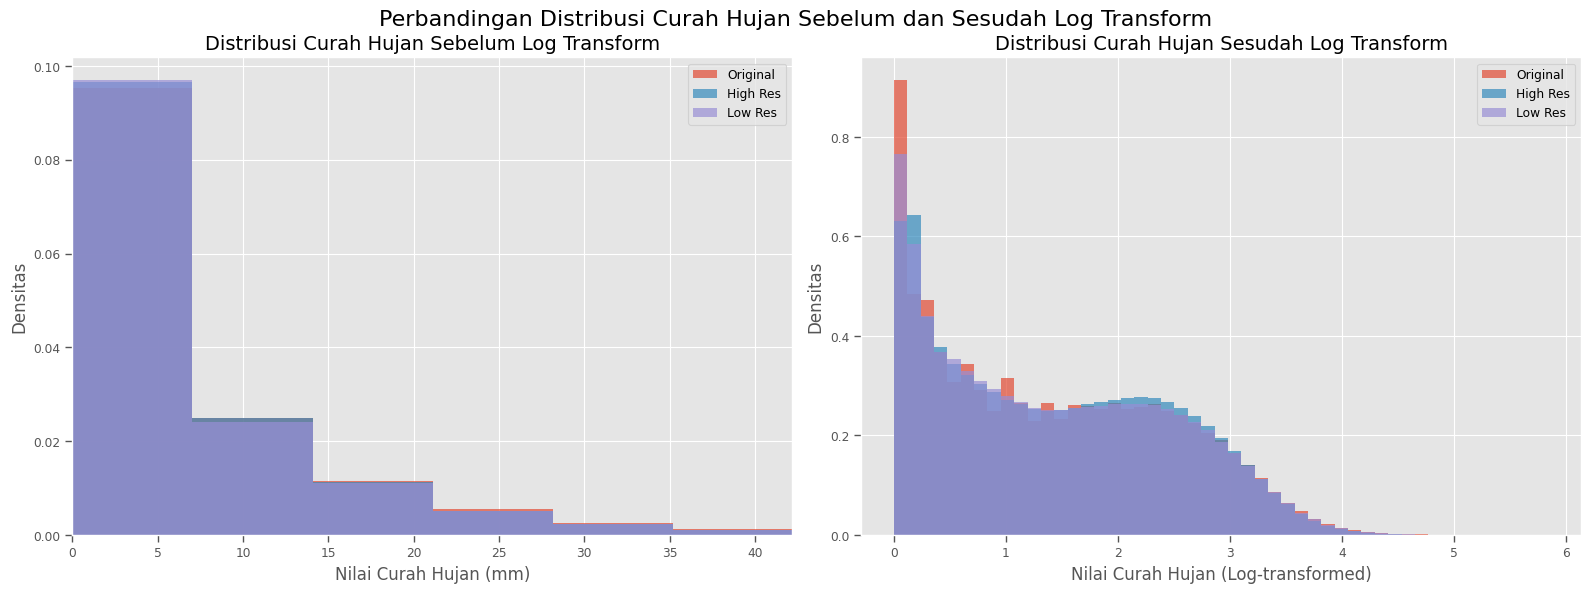

In [17]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

# Set style
plt.style.use('ggplot')
sns.set_context("paper")

# Create a figure with two subplots side by side
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Data untuk plotting (gunakan training data)
# Sebelum Log Transform - menggunakan .values.flatten() untuk DataArray
original_data = precipTrain.values.flatten() if hasattr(precipTrain, 'values') else precipTrain.flatten()
high_res_data = precipHighResTrain.values.flatten() if hasattr(precipHighResTrain, 'values') else precipHighResTrain.flatten()
low_res_data = precipLowResTrain.values.flatten() if hasattr(precipLowResTrain, 'values') else precipLowResTrain.flatten()

# Sesudah Log Transform
original_data_lt = precipTrain_LT.values.flatten() if hasattr(precipTrain_LT, 'values') else precipTrain_LT.flatten()
high_res_data_lt = precipHighResTrain_LT.values.flatten() if hasattr(precipHighResTrain_LT, 'values') else precipHighResTrain_LT.flatten()
low_res_data_lt = precipLowResTrain_LT.values.flatten() if hasattr(precipLowResTrain_LT, 'values') else precipLowResTrain_LT.flatten()

# Filter out any zeros or very small values for better visualization
original_data = original_data[original_data > 0.01]
high_res_data = high_res_data[high_res_data > 0.01]
low_res_data = low_res_data[low_res_data > 0.01]

# Setting bins
bins = np.linspace(0, max(np.max(original_data), np.max(high_res_data), np.max(low_res_data)), 50)
bins_lt = np.linspace(0, max(np.max(original_data_lt), np.max(high_res_data_lt), np.max(low_res_data_lt)), 50)

# Plot histogram sebelum log transform
axes[0].hist(original_data, bins=bins, alpha=0.7, label='Original', density=True)
axes[0].hist(high_res_data, bins=bins, alpha=0.7, label='High Res', density=True)
axes[0].hist(low_res_data, bins=bins, alpha=0.7, label='Low Res', density=True)
axes[0].set_title('Distribusi Curah Hujan Sebelum Log Transform', fontsize=14)
axes[0].set_xlabel('Nilai Curah Hujan (mm)', fontsize=12)
axes[0].set_ylabel('Densitas', fontsize=12)
axes[0].legend()
axes[0].set_xlim(0, np.percentile(original_data, 99))  # Limit x-axis for better visualization

# Plot histogram sesudah log transform
axes[1].hist(original_data_lt, bins=bins_lt, alpha=0.7, label='Original', density=True)
axes[1].hist(high_res_data_lt, bins=bins_lt, alpha=0.7, label='High Res', density=True)
axes[1].hist(low_res_data_lt, bins=bins_lt, alpha=0.7, label='Low Res', density=True)
axes[1].set_title('Distribusi Curah Hujan Sesudah Log Transform', fontsize=14)
axes[1].set_xlabel('Nilai Curah Hujan (Log-transformed)', fontsize=12)
axes[1].set_ylabel('Densitas', fontsize=12)
axes[1].legend()

# Add overall title
plt.suptitle('Perbandingan Distribusi Curah Hujan Sebelum dan Sesudah Log Transform', fontsize=16)

# Adjust layout
plt.tight_layout()
plt.subplots_adjust(top=0.9)

# Show plot
plt.show()

# Optional: Save figure
# plt.savefig('distribusi_curah_hujan.png', dpi=300, bbox_inches='tight')

In [22]:
print(np.max(original_data))
print(np.max(original_data_lt))

344.8125
5.8461857


In [24]:
# Script untuk menghitung statistik data sebelum dan sesudah log transform
import numpy as np
import pandas as pd

def calculate_statistics(data, data_name):
    """
    Menghitung statistik dasar dari data
    Mendukung numpy array dan xarray DataArray
    """
    # Konversi ke numpy array jika data adalah xarray DataArray
    if hasattr(data, 'values'):
        data_array = data.values.flatten()
    else:
        data_array = np.array(data).flatten()
    
    # Hapus NaN values jika ada
    data_clean = data_array[~np.isnan(data_array)]
    
    stats = {
        'Dataset': data_name,
        'Min': np.min(data_clean),
        'Max': np.max(data_clean),
        'Mean': np.mean(data_clean),
        'Median': np.median(data_clean),
        'Std': np.std(data_clean),
        'Variance': np.var(data_clean),
        'Q1': np.percentile(data_clean, 25),
        'Q3': np.percentile(data_clean, 75),
        'IQR': np.percentile(data_clean, 75) - np.percentile(data_clean, 25),
        'Data_Points': len(data_clean)
    }
    return stats

def print_comparison_stats(original_data, transformed_data, dataset_name):
    """
    Membandingkan statistik data original dan transformed
    """
    print(f"\n=== STATISTIK UNTUK {dataset_name.upper()} ===")
    print("-" * 70)
    
    # Statistik data original
    original_stats = calculate_statistics(original_data, f"{dataset_name} (Original)")
    transformed_stats = calculate_statistics(transformed_data, f"{dataset_name} (Log Transform)")
    
    # Format output
    print(f"{'Metric':<15} {'Original':<15} {'Log Transform':<15} {'Perubahan':<15}")
    print("-" * 70)
    
    metrics = ['Min', 'Max', 'Mean', 'Median', 'Std', 'Variance']
    for metric in metrics:
        orig_val = original_stats[metric]
        trans_val = transformed_stats[metric]
        change = trans_val - orig_val if metric != 'Variance' else (trans_val - orig_val)
        
        print(f"{metric:<15} {orig_val:<15.6f} {trans_val:<15.6f} {change:<15.6f}")
    
    print(f"{'Q1':<15} {original_stats['Q1']:<15.6f} {transformed_stats['Q1']:<15.6f}")
    print(f"{'Q3':<15} {original_stats['Q3']:<15.6f} {transformed_stats['Q3']:<15.6f}")
    print(f"{'IQR':<15} {original_stats['IQR']:<15.6f} {transformed_stats['IQR']:<15.6f}")

# Log Transformation dengan statistik
if DoPreProcessing:
    print('Performing PreProcessing with Statistical Analysis')
    print("=" * 80)
    
    # Log transformation
    precipTrain_LT         = logTransform(precipTrain)
    precipVal_LT           = logTransform(precipVal)
    precipTest_LT          = logTransform(precipTest)
    precipHighResTrain_LT  = logTransform(precipHighResTrain)
    precipHighResVal_LT    = logTransform(precipHighResVal)
    precipHighResTest_LT   = logTransform(precipHighResTest)
    precipLowResTrain_LT   = logTransform(precipLowResTrain)
    precipLowResVal_LT     = logTransform(precipLowResVal)
    precipLowResTest_LT    = logTransform(precipLowResTest)
    
    # Menghitung dan menampilkan statistik untuk setiap dataset
    datasets = [
        (precipTrain, precipTrain_LT, "Training Data"),
        (precipVal, precipVal_LT, "Validation Data"),
        (precipTest, precipTest_LT, "Test Data"),
        (precipHighResTrain, precipHighResTrain_LT, "High Res Training"),
        (precipHighResVal, precipHighResVal_LT, "High Res Validation"),
        (precipHighResTest, precipHighResTest_LT, "High Res Test"),
        (precipLowResTrain, precipLowResTrain_LT, "Low Res Training"),
        (precipLowResVal, precipLowResVal_LT, "Low Res Validation"),
        (precipLowResTest, precipLowResTest_LT, "Low Res Test")
    ]
    
    # Menampilkan statistik untuk setiap dataset
    for original, transformed, name in datasets:
        print_comparison_stats(original, transformed, name)
    
    # Summary statistik gabungan
    print("\n" + "=" * 80)
    print("RINGKASAN STATISTIK GABUNGAN")
    print("=" * 80)
    
    # Gabungkan semua data original dan transformed
    def flatten_data(data):
        """Helper function untuk flatten data xarray atau numpy"""
        if hasattr(data, 'values'):
            return data.values.flatten()
        else:
            return np.array(data).flatten()
    
    all_original = np.concatenate([
        flatten_data(precipTrain), flatten_data(precipVal), flatten_data(precipTest),
        flatten_data(precipHighResTrain), flatten_data(precipHighResVal), flatten_data(precipHighResTest),
        flatten_data(precipLowResTrain), flatten_data(precipLowResVal), flatten_data(precipLowResTest)
    ])
    
    all_transformed = np.concatenate([
        flatten_data(precipTrain_LT), flatten_data(precipVal_LT), flatten_data(precipTest_LT),
        flatten_data(precipHighResTrain_LT), flatten_data(precipHighResVal_LT), flatten_data(precipHighResTest_LT),
        flatten_data(precipLowResTrain_LT), flatten_data(precipLowResVal_LT), flatten_data(precipLowResTest_LT)
    ])
    
    # Hapus NaN values untuk analisis
    all_original_clean = all_original[~np.isnan(all_original)]
    all_transformed_clean = all_transformed[~np.isnan(all_transformed)]
    
    print_comparison_stats(all_original_clean, all_transformed_clean, "Semua Data")
    
    # Analisis distribusi
    print("\n" + "=" * 80)
    print("ANALISIS DISTRIBUSI")
    print("=" * 80)
    
    # Hitung skewness dan kurtosis jika tersedia
    try:
        from scipy import stats
        
        original_skew = stats.skew(all_original_clean)
        transformed_skew = stats.skew(all_transformed_clean)
        original_kurtosis = stats.kurtosis(all_original_clean)
        transformed_kurtosis = stats.kurtosis(all_transformed_clean)
        
        print(f"{'Metric':<20} {'Original':<15} {'Log Transform':<15}")
        print("-" * 50)
        print(f"{'Skewness':<20} {original_skew:<15.6f} {transformed_skew:<15.6f}")
        print(f"{'Kurtosis':<20} {original_kurtosis:<15.6f} {transformed_kurtosis:<15.6f}")
        
        # Interpretasi skewness
        print(f"\nInterpretasi Skewness:")
        print(f"Original: {'Right-skewed' if original_skew > 0 else 'Left-skewed' if original_skew < 0 else 'Symmetric'}")
        print(f"Transformed: {'Right-skewed' if transformed_skew > 0 else 'Left-skewed' if transformed_skew < 0 else 'Symmetric'}")
        
    except ImportError:
        print("Scipy tidak tersedia untuk menghitung skewness dan kurtosis")
    
    print(f"\nJumlah total data points: {len(all_original_clean):,}")
    print(f"Persentase data dengan nilai 0 (original): {(all_original_clean == 0).sum()/len(all_original_clean)*100:.2f}%")
    
    # Cek untuk nilai ekstrem
    original_outliers = len(all_original_clean[all_original_clean > (np.percentile(all_original_clean, 75) + 1.5 * (np.percentile(all_original_clean, 75) - np.percentile(all_original_clean, 25)))])
    transformed_outliers = len(all_transformed_clean[all_transformed_clean > (np.percentile(all_transformed_clean, 75) + 1.5 * (np.percentile(all_transformed_clean, 75) - np.percentile(all_transformed_clean, 25)))])
    
    print(f"Jumlah outliers (original): {original_outliers}")
    print(f"Jumlah outliers (transformed): {transformed_outliers}")
    
    print("\n" + "=" * 80)
    print("PreProcessing dan Analisis Statistik Selesai!")
    print("=" * 80)

Performing PreProcessing with Statistical Analysis

=== STATISTIK UNTUK TRAINING DATA ===
----------------------------------------------------------------------
Metric          Original        Log Transform   Perubahan      
----------------------------------------------------------------------
Min             0.000000        0.095310        0.095310       
Max             344.812500      5.846186        -338.966309    
Mean            6.182640        1.415489        -4.767151      
Median          2.500000        1.280934        -1.219066      
Std             9.117889        1.046428        -8.071461      
Variance        83.135902       1.095012        -82.040894     
Q1              0.437500        0.430158       
Q3              8.500000        2.261763       
IQR             8.062500        1.831605       

=== STATISTIK UNTUK VALIDATION DATA ===
----------------------------------------------------------------------
Metric          Original        Log Transform   Perubahan      


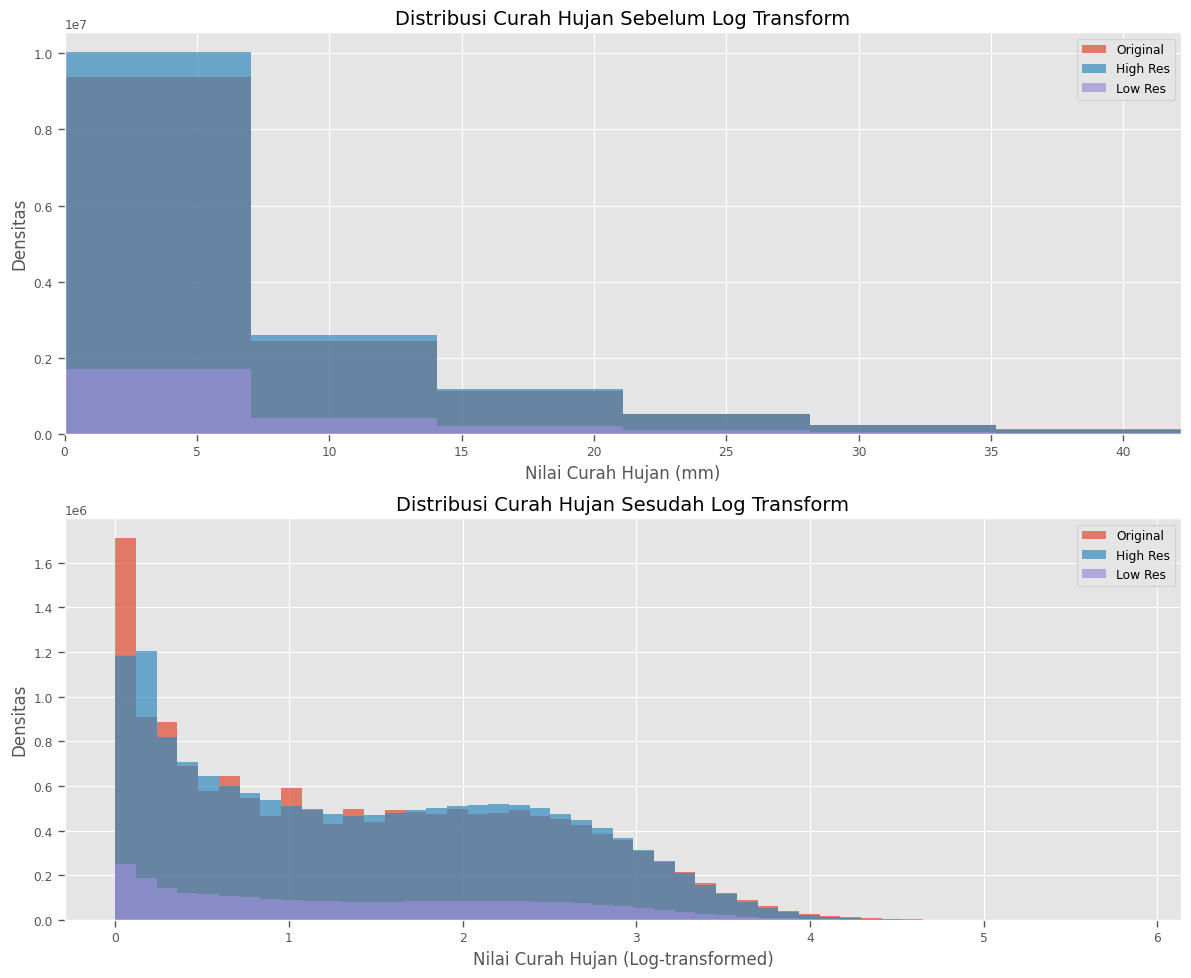

In [22]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

# Set style
plt.style.use('ggplot')
sns.set_context("paper")

# Create a figure with two subplots stacked vertically (atas-bawah)
fig, axes = plt.subplots(2, 1, figsize=(12, 10))  # Mengubah dari (1, 2) menjadi (2, 1) dan menyesuaikan ukuran

# Data untuk plotting (gunakan training data)
# Sebelum Log Transform - menggunakan .values.flatten() untuk DataArray
original_data = precipTrain.values.flatten() if hasattr(precipTrain, 'values') else precipTrain.flatten()
high_res_data = precipHighResTrain.values.flatten() if hasattr(precipHighResTrain, 'values') else precipHighResTrain.flatten()
low_res_data = precipLowResTrain.values.flatten() if hasattr(precipLowResTrain, 'values') else precipLowResTrain.flatten()

# Sesudah Log Transform
original_data_lt = precipTrain_LT.values.flatten() if hasattr(precipTrain_LT, 'values') else precipTrain_LT.flatten()
high_res_data_lt = precipHighResTrain_LT.values.flatten() if hasattr(precipHighResTrain_LT, 'values') else precipHighResTrain_LT.flatten()
low_res_data_lt = precipLowResTrain_LT.values.flatten() if hasattr(precipLowResTrain_LT, 'values') else precipLowResTrain_LT.flatten()

# Filter out any zeros or very small values for better visualization
original_data = original_data[original_data > 0.01]
high_res_data = high_res_data[high_res_data > 0.01]
low_res_data = low_res_data[low_res_data > 0.01]

# Setting bins
bins = np.linspace(0, max(np.max(original_data), np.max(high_res_data), np.max(low_res_data)), 50)
bins_lt = np.linspace(0, max(np.max(original_data_lt), np.max(high_res_data_lt), np.max(low_res_data_lt)), 50)

# Plot histogram sebelum log transform (subplot atas)
axes[0].hist(original_data, bins=bins, alpha=0.7, label='Original', density=False)
axes[0].hist(high_res_data, bins=bins, alpha=0.7, label='High Res', density=False)
axes[0].hist(low_res_data, bins=bins, alpha=0.7, label='Low Res', density=False)
axes[0].set_title('Distribusi Curah Hujan Sebelum Log Transform', fontsize=14)
axes[0].set_xlabel('Nilai Curah Hujan (mm)', fontsize=12)
axes[0].set_ylabel('Densitas', fontsize=12)
axes[0].legend()
axes[0].set_xlim(0, np.percentile(original_data, 99))  # Limit x-axis for better visualization

# Plot histogram sesudah log transform (subplot bawah)
axes[1].hist(original_data_lt, bins=bins_lt, alpha=0.7, label='Original', density=False)
axes[1].hist(high_res_data_lt, bins=bins_lt, alpha=0.7, label='High Res', density=False)
axes[1].hist(low_res_data_lt, bins=bins_lt, alpha=0.7, label='Low Res', density=False)
axes[1].set_title('Distribusi Curah Hujan Sesudah Log Transform', fontsize=14)
axes[1].set_xlabel('Nilai Curah Hujan (Log-transformed)', fontsize=12)
axes[1].set_ylabel('Densitas', fontsize=12)
axes[1].legend()



# Adjust layout
plt.tight_layout()
plt.subplots_adjust(top=0.95)  # Memberi ruang untuk judul utama

# Show plot
plt.show()

# Optional: Save figure
# plt.savefig('distribusi_curah_hujan_vertical.png', dpi=300, bbox_inches='tight')

In [ ]:
# Modified Log Transformation

# def preprocess_log_minmax(x, x_min=None, x_max=None):
#     x_log = np.log1p(x)  # log(1 + x), safe for zeros
#     if x_min is None:
#         x_min = x_log.min()
#     if x_max is None:
#         x_max = x_log.max()
#     x_scaled = (x_log - x_min) / (x_max - x_min)
#     return x_scaled, x_min, x_max


# if DoPreProcessing:
#     # print('Performing PreProcessing')
#     # # Log transformation with epsilon
#     # precipTrain         = logTransform(precipTrain)
#     # precipVal           = logTransform(precipVal)
#     # precipTest          = logTransform(precipTest)

#     # precipHighResTrain  = logTransform(precipHighResTrain)
#     # precipHighResVal    = logTransform(precipHighResVal)
#     # precipHighResTest   = logTransform(precipHighResTest)

#     # precipLowResTrain   = logTransform(precipLowResTrain)
#     # precipLowResVal     = logTransform(precipLowResVal)
#     # precipLowResTest    = logTransform(precipLowResTest)

#     precipTrain, min_, max_ = preprocess_log_minmax(precipTrain)
#     precipHighResTrain, _, _ = preprocess_log_minmax(precipHighResTrain, min_, max_)
#     precipLowResTrain, _, _ = preprocess_log_minmax(precipLowResTrain, min_, max_)

#     # Validation: use same min/max
#     precipVal, _, _ = preprocess_log_minmax(precipVal, min_, max_)
#     precipHighResVal, _, _ = preprocess_log_minmax(precipHighResVal, min_, max_)
#     precipLowResVal, _, _ = preprocess_log_minmax(precipLowResVal, min_, max_)

#     # Test: use same min/max
#     precipTest, _, _ = preprocess_log_minmax(precipTest, min_, max_)
#     precipHighResTest, _, _ = preprocess_log_minmax(precipHighResTest, min_, max_)
#     precipLowResTest, _, _ = preprocess_log_minmax(precipLowResTest, min_, max_)

In [ ]:
# from sklearn.preprocessing import QuantileTransformer

# # Quantile Transformation

# if DoPreProcessing:
#     print('Performing PreProcessing with Quantile Transformation')

#     # Flatten and fit QuantileTransformer
#     qt = QuantileTransformer(output_distribution='normal', random_state=42)

#     precipTrain_flat         = precipTrain.values.reshape(-1, 1)
#     precipVal_flat           = precipVal.values.reshape(-1, 1)
#     precipTest_flat          = precipTest.values.reshape(-1, 1)

#     precipHighResTrain_flat  = precipHighResTrain.values.reshape(-1, 1)
#     precipHighResVal_flat    = precipHighResVal.values.reshape(-1, 1)
#     precipHighResTest_flat   = precipHighResTest.values.reshape(-1, 1)

#     precipLowResTrain_flat   = precipLowResTrain.values.reshape(-1, 1)
#     precipLowResVal_flat     = precipLowResVal.values.reshape(-1, 1)
#     precipLowResTest_flat    = precipLowResTest.values.reshape(-1, 1)

#     # Fit only on train data
#     precipTrain_trans      = qt.fit_transform(precipTrain_flat)
#     precipVal_trans        = qt.transform(precipVal_flat)
#     precipTest_trans       = qt.transform(precipTest_flat)

#     precipHighResTrain_trans = qt.transform(precipHighResTrain_flat)
#     precipHighResVal_trans   = qt.transform(precipHighResVal_flat)
#     precipHighResTest_trans  = qt.transform(precipHighResTest_flat)

#     precipLowResTrain_trans  = qt.transform(precipLowResTrain_flat)
#     precipLowResVal_trans    = qt.transform(precipLowResVal_flat)
#     precipLowResTest_trans   = qt.transform(precipLowResTest_flat)

#     # Reshape back to original
#     precipTrain         = precipTrain_trans.reshape(precipTrain.shape)
#     precipVal           = precipVal_trans.reshape(precipVal.shape)
#     precipTest          = precipTest_trans.reshape(precipTest.shape)

#     precipHighResTrain  = precipHighResTrain_trans.reshape(precipHighResTrain.shape)
#     precipHighResVal    = precipHighResVal_trans.reshape(precipHighResVal.shape)
#     precipHighResTest   = precipHighResTest_trans.reshape(precipHighResTest.shape)

#     precipLowResTrain   = precipLowResTrain_trans.reshape(precipLowResTrain.shape)
#     precipLowResVal     = precipLowResVal_trans.reshape(precipLowResVal.shape)
#     precipLowResTest    = precipLowResTest_trans.reshape(precipLowResTest.shape)

## Normalize data (0 to 1 range)

In [ ]:
print('LowResTrain shape:', precipLowResTrain.shape)

In [ ]:
if Normalized:
    print('Performing Data Normalization')
    # Apply Scaler (fit only on training data)
    scaler              = MinMaxScaler()
    scaledTrain         = scaler.fit_transform(precipTrain.values.reshape(-1, 1))

    # Normalize validation and test sets using the same scaler
    scaledVal           = scaler.transform(precipVal.values.reshape(-1, 1))
    scaledTesting       = scaler.transform(precipTest.values.reshape(-1, 1))

    scaledLowResTrain   = scaler.transform(precipLowResTrain.values.reshape(-1, 1))
    scaledLowResVal     = scaler.transform(precipLowResVal.values.reshape(-1, 1))
    scaledLowResTest    = scaler.transform(precipLowResTest.values.reshape(-1, 1))

    scaledHighResTrain  = scaler.transform(precipHighResTrain.values.reshape(-1, 1))
    scaledHighResVal    = scaler.transform(precipHighResVal.values.reshape(-1, 1))
    scaledHighResTest   = scaler.transform(precipHighResTest.values.reshape(-1, 1))

    # Reshape back to original shape
    precipTrain         = scaledTrain.reshape(precipTrain.shape)
    precipVal           = scaledVal.reshape(precipVal.shape)
    precipTest          = scaledTesting.reshape(precipTest.shape)

    precipLowResTrain   = scaledLowResTrain.reshape(precipLowResTrain.shape)
    precipLowResVal     = scaledLowResVal.reshape(precipLowResVal.shape)
    precipLowResTest    = scaledLowResTest.reshape(precipLowResTest.shape)

    precipHighResTrain  = scaledHighResTrain.reshape(precipHighResTrain.shape)
    precipHighResVal    = scaledHighResVal.reshape(precipHighResVal.shape)
    precipHighResTest   = scaledHighResTest.reshape(precipHighResTest.shape)


In [ ]:
# if Normalized:
#     print('Performing Data Normalization')
#     # Apply Scaler (fit only on training data)
#     scaler = MinMaxScaler()
#     scaledTrain         = scaler.fit_transform(precipTrain.reshape(-1, 1))

#     # Normalize validation and test sets using the same scaler
#     scaledVal           = scaler.transform(precipVal.reshape(-1, 1))
#     scaledTesting       = scaler.transform(precipTest.reshape(-1, 1))

#     scaledLowResTrain   = scaler.transform(precipLowResTrain.reshape(-1, 1))
#     scaledLowResVal     = scaler.transform(precipLowResVal.reshape(-1, 1))
#     scaledLowResTest    = scaler.transform(precipLowResTest.reshape(-1, 1))

#     scaledHighResTrain  = scaler.transform(precipHighResTrain.reshape(-1, 1))
#     scaledHighResVal    = scaler.transform(precipHighResVal.reshape(-1, 1))
#     scaledHighResTest   = scaler.transform(precipHighResTest.reshape(-1, 1))

#     # Reshape back to original shape
#     precipTrain         = scaledTrain.reshape(precipTrain.shape)
#     precipVal           = scaledVal.reshape(precipVal.shape)
#     precipTest          = scaledTesting.reshape(precipTest.shape)

#     precipLowResTrain   = scaledLowResTrain.reshape(precipLowResTrain.shape)
#     precipLowResVal     = scaledLowResVal.reshape(precipLowResVal.shape)
#     precipLowResTest    = scaledLowResTest.reshape(precipLowResTest.shape)

#     precipHighResTrain  = scaledHighResTrain.reshape(precipHighResTrain.shape)
#     precipHighResVal    = scaledHighResVal.reshape(precipHighResVal.shape)
#     precipHighResTest   = scaledHighResTest.reshape(precipHighResTest.shape)


## Reshape for CNN input format

In [ ]:
# Reshape for CNN input format (TensorFlow format: [Samples, Height, Width, Channels])
precipTrain       = np.expand_dims(precipTrain, axis=-1)  # Shape: [T, H, W, 1]
precipVal         = np.expand_dims(precipVal, axis=-1)  
precipTest        = np.expand_dims(precipTest, axis=-1)  

precipTrain       = np.nan_to_num(precipTrain, nan=0)
precipVal         = np.nan_to_num(precipVal, nan=0)
precipTest        = np.nan_to_num(precipTest, nan=0)

precipLowResTrain   = np.expand_dims(precipLowResTrain, axis=-1)  # Shape: [T, H, W, 1]
precipLowResVal     = np.expand_dims(precipLowResVal, axis=-1)  
precipLowResTest    = np.expand_dims(precipLowResTest, axis=-1)  

precipLowResTrain   = np.nan_to_num(precipLowResTrain, nan=0)
precipLowResVal     = np.nan_to_num(precipLowResVal, nan=0)
precipLowResTest    = np.nan_to_num(precipLowResTest, nan=0)

precipHighResTrain   = np.expand_dims(precipHighResTrain, axis=-1)  # Shape: [T, H, W, 1]
precipHighResVal     = np.expand_dims(precipHighResVal, axis=-1)  
precipHighResTest    = np.expand_dims(precipHighResTest, axis=-1)  

precipHighResTrain   = np.nan_to_num(precipHighResTrain, nan=0)
precipHighResVal     = np.nan_to_num(precipHighResVal, nan=0)
precipHighResTest    = np.nan_to_num(precipHighResTest, nan=0)

## Create HDF5 file and write dataset

In [ ]:
with h5py.File(hdf5Training, "w") as hf:
    hf.create_dataset("precipTrainOriginal", data=precipTrain, compression="gzip")
    hf.create_dataset("precipLowResTrain", data=precipLowResTrain, compression="gzip")
    hf.create_dataset("precipHighResTrain", data=precipHighResTrain, compression="gzip")
    
    hf.create_dataset("latOriginal", data=latOriginal, compression="gzip")
    hf.create_dataset("lonOriginal", data=lonOriginal, compression="gzip")
    hf.create_dataset("latLowRes", data=latLowRes, compression="gzip")
    hf.create_dataset("lonLowRes", data=lonLowRes, compression="gzip")
    hf.create_dataset("latHighRes", data=latHighRes, compression="gzip")
    hf.create_dataset("lonHighRes", data=lonHighRes, compression="gzip")
    
    hf.create_dataset("timeOriginalTrain", data=convertTime(timeOriginalTrain), compression="gzip")
    hf.create_dataset("timeHighResTrain", data=convertTime(timeHighResTrain), compression="gzip")
    hf.create_dataset("timeLowResTrain", data=convertTime(timeLowResTrain), compression="gzip")

    if Normalized:
        hf.create_dataset("scale_", data=scaler.scale_)         # Saving Min Max Scaler Parameter
        hf.create_dataset("min_", data=scaler.min_)
        hf.create_dataset("data_min_", data=scaler.data_min_)
        hf.create_dataset("data_max_", data=scaler.data_max_)
        hf.create_dataset("feature_range", data=np.array(scaler.feature_range))
  
with h5py.File(hdf5Validation, "w") as hf:
    hf.create_dataset("precipValOriginal", data=precipVal, compression="gzip")
    hf.create_dataset("precipLowResVal", data=precipLowResVal, compression="gzip")
    hf.create_dataset("precipHighResVal", data=precipHighResVal, compression="gzip")
    
    hf.create_dataset("latOriginal", data=latOriginal, compression="gzip")
    hf.create_dataset("lonOriginal", data=lonOriginal, compression="gzip")
    hf.create_dataset("latLowRes", data=latLowRes, compression="gzip")
    hf.create_dataset("lonLowRes", data=lonLowRes, compression="gzip")
    hf.create_dataset("latHighRes", data=latHighRes, compression="gzip")
    hf.create_dataset("lonHighRes", data=lonHighRes, compression="gzip")
    
    hf.create_dataset("timeOriginalVal", data=convertTime(timeOriginalVal), compression="gzip")
    hf.create_dataset("timeHighResVal", data=convertTime(timeHighResVal), compression="gzip")
    hf.create_dataset("timeLowResVal", data=convertTime(timeLowResVal), compression="gzip")
    
with h5py.File(hdf5Testing, "w") as hf:
    hf.create_dataset("precipTestOriginal", data=precipTest, compression="gzip")
    hf.create_dataset("precipLowResTest", data=precipLowResTest, compression="gzip")
    hf.create_dataset("precipHighResTest", data=precipHighResTest, compression="gzip")
    
    hf.create_dataset("latOriginal", data=latOriginal, compression="gzip")
    hf.create_dataset("lonOriginal", data=lonOriginal, compression="gzip")
    hf.create_dataset("latLowRes", data=latLowRes, compression="gzip")
    hf.create_dataset("lonLowRes", data=lonLowRes, compression="gzip")
    hf.create_dataset("latHighRes", data=latHighRes, compression="gzip")
    hf.create_dataset("lonHighRes", data=lonHighRes, compression="gzip")
    
    hf.create_dataset("timeOriginalTest", data=convertTime(timeOriginalTest), compression="gzip") 
    hf.create_dataset("timeHighResTest", data=convertTime(timeHighResTest), compression="gzip") 
    hf.create_dataset("timeLowResTest", data=convertTime(timeLowResTest), compression="gzip") 
    
print(f"Dataset saved: {hdf5Training}")    
print(f"Dataset saved: {hdf5Validation}")
print(f"Dataset saved: {hdf5Testing}")

## Load dataset from HDF5

In [ ]:
# Load dataset from HDF5
with h5py.File(hdf5Training, "r") as hf:
    precipTrainOriginal = hf["precipTrainOriginal"][:]
    precipLowResTrain   = hf["precipLowResTrain"][:]
    precipHighResTrain  = hf["precipHighResTrain"][:]
    
    timeOriginalTrain   = hf["timeOriginalTrain"][:]
    timeHighResTrain    = hf["timeHighResTrain"][:]
    timeLowResTrain     = hf["timeLowResTrain"][:]
    
    latOriginal         = hf["latOriginal"][:]
    lonOriginal         = hf["lonOriginal"][:]
    latLowRes           = hf["latLowRes"][:]
    lonLowRes           = hf["lonLowRes"][:]
    latHighRes          = hf["latHighRes"][:]
    lonHighRes          = hf["lonHighRes"][:]
    
    if Normalized:
        scale_          = hf["scale_"][:]           # Loading Min Max Scaler Parameter
        min_            = hf["min_"][:]
        data_min_       = hf["data_min_"][:]
        data_max_       = hf["data_max_"][:]
        feature_range   = hf["feature_range"][:]        
    print("Loaded Original Train Data Shape:", precipHighResTrain.shape)

with h5py.File(hdf5Validation, "r") as hf:
    precipValOriginal   = hf["precipValOriginal"][:]
    precipLowResVal     = hf["precipLowResVal"][:]
    precipHighResVal    = hf["precipHighResVal"][:]
    
    timeOriginalVal     = hf["timeOriginalVal"][:]
    timeHighResVal      = hf["timeHighResVal"][:]
    timeLowResVal       = hf["timeLowResVal"][:]
    
    print("Loaded Original Validation Data Shape:", precipHighResVal.shape)
    
with h5py.File(hdf5Testing, "r") as hf:
    precipTestOriginal  = hf["precipTestOriginal"][:]
    precipLowResTest    = hf["precipLowResTest"][:]
    precipHighResTest   = hf["precipHighResTest"][:]
    
    timeOriginalTest    = hf["timeOriginalTest"][:]
    timeHighResTest     = hf["timeHighResTest"][:]
    timeLowResTest      = hf["timeLowResTest"][:]
    
    print("Loaded Original Test Data Shape:", precipHighResTest.shape)   


## Invers to Original Data

In [ ]:
# Invers to original precipitation data
if Normalized:
    # Recreate Min Max Scaler with saved parameters
    print('Invers to original precipitation data using Min Max Scaller')
    scaler              = MinMaxScaler()
    scaler.scale_       = scale_ 
    scaler.min_         = min_
    scaler.data_min_    = data_min_
    scaler.data_max_    = data_max_
    scaler.feature_range = feature_range
    
    precipTrainOriginal = inversTransform(scaler, precipTrainOriginal)
    precipValOriginal   = inversTransform(scaler, precipValOriginal)
    precipTestOriginal  = inversTransform(scaler, precipTestOriginal)
    
    precipLowResTrain   = inversTransform(scaler, precipLowResTrain)
    precipLowResVal     = inversTransform(scaler, precipLowResVal)
    precipLowResTest    = inversTransform(scaler, precipLowResTest)
    
    precipHighResTrain  = inversTransform(scaler, precipHighResTrain)
    precipHighResVal    = inversTransform(scaler, precipHighResVal)
    precipHighResTest   = inversTransform(scaler, precipHighResTest)

# Invers to original precipitation data
if DoPreProcessing:
    print('Invers to original precipitation data using Log Transformation')
    
    precipTrainOriginal = inverseLogTransform(precipTrainOriginal)
    precipValOriginal   = inverseLogTransform(precipValOriginal)
    precipTestOriginal  = inverseLogTransform(precipTestOriginal)
    
    precipLowResTrain   = inverseLogTransform(precipLowResTrain)
    precipLowResVal     = inverseLogTransform(precipLowResVal)
    precipLowResTest    = inverseLogTransform(precipLowResTest)
    
    precipHighResTrain  = inverseLogTransform(precipHighResTrain)
    precipHighResVal    = inverseLogTransform(precipHighResVal)
    precipHighResTest   = inverseLogTransform(precipHighResTest)

In [ ]:
# Combine ALL data (Train + Validation + Test)
precipOriginalAll = np.concatenate([
    precipTrainOriginal[:, :, :, 0],
    precipValOriginal[:, :, :, 0],
    precipTestOriginal[:, :, :, 0]
], axis=0)

precipLowResAll = np.concatenate([
    precipLowResTrain[:, :, :, 0],
    precipLowResVal[:, :, :, 0],
    precipLowResTest[:, :, :, 0]
], axis=0)

precipHighResAll = np.concatenate([
    precipHighResTrain[:, :, :, 0],
    precipHighResVal[:, :, :, 0],
    precipHighResTest[:, :, :, 0]
], axis=0)

# Combine all time coordinates
timeOriginalAll = np.concatenate([timeOriginalTrain, timeOriginalVal, timeOriginalTest])
timeLowResAll   = np.concatenate([timeLowResTrain, timeLowResVal, timeLowResTest])
timeHighResAll  = np.concatenate([timeHighResTrain, timeHighResVal, timeHighResTest])

# Convert to XARRAY object
dsOriginal  = image2Xarray(precipOriginalAll, lonOriginal, latOriginal, timeOriginalAll)
dsLowRes    = image2Xarray(precipLowResAll, lonLowRes, latLowRes, timeLowResAll)
dsHighRes   = image2Xarray(precipHighResAll, lonHighRes, latHighRes, timeHighResAll)

In [ ]:
print(lonOriginal)

## Display Precipitation

In [ ]:
# Extract precipitation data
specificDate    = np.datetime64('2009-01-15')  # Replace with your target date
precipOriginal  = selectPrecipitation(dsOriginal, specificDate)
precipLowRes    = selectPrecipitation(dsLowRes, specificDate)
precipHighRes   = selectPrecipitation(dsHighRes, specificDate)

# Create figure with Cartopy projection
fig, ax = plt.subplots(3, 1, figsize=(20, 20), subplot_kw={'projection': ccrs.PlateCarree()})

# Plot precipitation data
precipOriginal.plot(ax=ax[0], cmap='Blues', transform=ccrs.PlateCarree(), cbar_kwargs={'label': 'Precipitation (mm)'})
precipLowRes.plot(ax=ax[1], cmap='Blues', transform=ccrs.PlateCarree(), cbar_kwargs={'label': 'Precipitation (mm)'})
precipHighRes.plot(ax=ax[2], cmap='Blues', transform=ccrs.PlateCarree(), cbar_kwargs={'label': 'Precipitation (mm)'})

# Add coastlines, country borders, and gridlines
ax[0].coastlines()
ax[0].add_feature(cfeature.BORDERS, linestyle=':')
ax[0].add_feature(cfeature.LAND, edgecolor='black', facecolor='lightgray', alpha=0.3)
ax[0].set_title(f"Original MSWEP Precipitation on {specificDate}")

# Add coastlines, country borders, and gridlines
ax[1].coastlines()
ax[1].add_feature(cfeature.BORDERS, linestyle=':')
ax[1].add_feature(cfeature.LAND, edgecolor='black', facecolor='lightgray', alpha=0.3)
ax[1].set_title(f"Low Resolution MSWEP Precipitation on {specificDate}")

# Add coastlines, country borders, and gridlines
ax[2].coastlines()
ax[2].add_feature(cfeature.BORDERS, linestyle=':')
ax[2].add_feature(cfeature.LAND, edgecolor='black', facecolor='lightgray', alpha=0.3)
ax[2].set_title(f"Interpolated MSWEP Precipitation on {specificDate}")

# Show plot
plt.show()

In [ ]:
# Extract precipitation data
specificDate    = np.datetime64('2023-01-15')  # Replace with your target date
precipOriginal  = selectPrecipitation(dsOriginal, specificDate)
precipLowRes    = selectPrecipitation(dsLowRes, specificDate)
precipHighRes   = selectPrecipitation(dsHighRes, specificDate)

# Create figure with Cartopy projection
fig, ax = plt.subplots(3, 1, figsize=(20, 20), subplot_kw={'projection': ccrs.PlateCarree()})

# Plot precipitation data
precipOriginal.plot(ax=ax[0], cmap='Blues', transform=ccrs.PlateCarree(), cbar_kwargs={'label': 'Precipitation (mm)'})
precipLowRes.plot(ax=ax[1], cmap='Blues', transform=ccrs.PlateCarree(), cbar_kwargs={'label': 'Precipitation (mm)'})
precipHighRes.plot(ax=ax[2], cmap='Blues', transform=ccrs.PlateCarree(), cbar_kwargs={'label': 'Precipitation (mm)'})

# Add coastlines, country borders, and gridlines
ax[0].coastlines()
ax[0].add_feature(cfeature.BORDERS, linestyle=':')
ax[0].add_feature(cfeature.LAND, edgecolor='black', facecolor='lightgray', alpha=0.3)
ax[0].set_title(f"Original MSWEP Precipitation on {specificDate}")

# Add coastlines, country borders, and gridlines
ax[1].coastlines()
ax[1].add_feature(cfeature.BORDERS, linestyle=':')
ax[1].add_feature(cfeature.LAND, edgecolor='black', facecolor='lightgray', alpha=0.3)
ax[1].set_title(f"Low Resolution MSWEP Precipitation on {specificDate}")

# Add coastlines, country borders, and gridlines
ax[2].coastlines()
ax[2].add_feature(cfeature.BORDERS, linestyle=':')
ax[2].add_feature(cfeature.LAND, edgecolor='black', facecolor='lightgray', alpha=0.3)
ax[2].set_title(f"Interpolated MSWEP Precipitation on {specificDate}")

# Show plot
plt.show()